In [2]:
# -*- coding:utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pyecharts import Bar,Line,Overlap,online
online() 

# np 和 pandas的设定
# np.random.seed(123)
np.set_printoptions(precision=4)
pd.set_option('display.float_format', lambda x: '%.4f' % x) # 不使用科学计数法
pd.set_option('display.max_columns', None) # 显示所有列
pd.set_option('display.max_rows', 20) # 设定df全部显示的行数

# import warnings
# warnings.filterwarnings('ignore') # 忽略警告提示

# 一个cell做多个输出
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

#设置中文显示的相关参数：
# import matplotlib as mpl
# mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['font.size'] = 4
plt.rcParams['axes.unicode_minus'] = False #解决负号显示为方框的问题
plt.rcParams['figure.figsize'] = (10, 6)


# 设置绘图风格 及 颜色变化
# plt.style.use('ggplot')  # 与sns的颜色设置有点冲突 最好以sns的设置为主
sns.set(color_codes = True, palette="muted")
sns.set_style('whitegrid',{'font.sans-serif':['Microsoft YaHei','Arial']})
sns.set_context("poster")
sns.set_context("talk", font_scale=0.6)

## 描述性分析
### 读取数据 及 维度整理 
> 由于原始数据维度较少，本次特征工程不考虑维度筛选，只进行维度衍生；

**数据概括：**    
- 字段含义：用户编码、订单日期、销售数量、订单金额     
- 数据为69659\*4, 前三列为int64类型，最后一列为float64类型，无数据丢失

In [3]:
# 读取原始数据
columns = ['member_id', 'order_date', 'goods_count', 'goods_sale']
data = pd.read_csv('./datasets/CDNOW.txt', names = columns, sep = '\s+')
data.head()

,member_id,order_date,goods_count,goods_sale
0,1,19970101,1,11.7700
1,2,19970112,1,12.0000
2,2,19970112,5,77.0000
3,3,19970102,2,20.7600
4,3,19970330,2,20.7600


In [4]:
# 数据规模 和 数据类型
data.shape
data.info()
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
member_id      69659 non-null int64
order_date     69659 non-null int64
goods_count    69659 non-null int64
goods_sale     69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


member_id        int64
order_date       int64
goods_count      int64
goods_sale     float64
dtype: object

In [5]:
# 数据缺失状况 数据不缺失
df_miss_rate = 1 - data.count()/len(data)
df_miss_rate.sort_values(ascending=False)

goods_sale    0.0000
goods_count   0.0000
order_date    0.0000
member_id     0.0000
dtype: float64

**维度扩充：**
- 时间维度扩充：包括时间数据转换、时间属性拆分等    
- 新用户判断：在整个数据集时间范围上，用户第一次购买（当天）为新用户，以后购买均为老用户(或者在更小的时间范围内判断)
- 用户消费总金额：整个时间范围内每个用户消费的总金额
- 用户消费总频次：整个时间范围内每个用户消费的总次数（因没有订单编码，默认每一行为一个订单）
- 用户购买总间隔：用户最后一次购买与第一次购买的间隔时长，单位为天   

> 改动版的RFM，后期尝试聚类+预测

In [6]:
df = data.copy()

# 1 时间数据处理 暂时未做时间序列，需要时在补充
df['order_date'] = pd.to_datetime(df.order_date, format='%Y%m%d')
df['year'] = df.order_date.map(lambda x:datetime.strftime(x,'%Y'))
df['month'] = df.order_date.map(lambda x:datetime.strftime(x,'%Y-%m'))
# df['day'] = df.order_date.map(lambda x:x.day)
df['weekOfMonth'] = df.order_date.map(lambda x: int(datetime(x.year, x.month, x.day).strftime("%W")) - int(datetime(x.year, x.month, 1).strftime("%W"))+1)
df['dayOfWeek'] = df.order_date.map(lambda x:datetime.strftime(x,'%A'))
df.sort_values(by=['order_date','member_id'], inplace=True)
df.head()

,member_id,order_date,goods_count,goods_sale,year,month,weekOfMonth,dayOfWeek
0,1,1997-01-01,1,11.7700,1997,1997-01,1,Wednesday
9,4,1997-01-01,2,29.3300,1997,1997-01,1,Wednesday
13,5,1997-01-01,2,29.3300,1997,1997-01,1,Wednesday
24,6,1997-01-01,1,20.9900,1997,1997-01,1,Wednesday
25,7,1997-01-01,2,28.7400,1997,1997-01,1,Wednesday


In [7]:
# 新用户判断
df_new_user = df.groupby(['member_id'],as_index=False)['order_date'].min()
df_new_user['is_new'] = 'Y'
df = pd.merge(left=df, right=df_new_user, how='left', on=['member_id','order_date'])
df['is_new'].fillna('N', inplace=True)
df.head()

,member_id,order_date,goods_count,goods_sale,year,month,weekOfMonth,dayOfWeek,is_new
0,1,1997-01-01,1,11.7700,1997,1997-01,1,Wednesday,Y
1,4,1997-01-01,2,29.3300,1997,1997-01,1,Wednesday,Y
2,5,1997-01-01,2,29.3300,1997,1997-01,1,Wednesday,Y
3,6,1997-01-01,1,20.9900,1997,1997-01,1,Wednesday,Y
4,7,1997-01-01,2,28.7400,1997,1997-01,1,Wednesday,Y


In [8]:
# 用户总消费金额、总消费频次和购买间隔
df1 = df.groupby(['member_id'],as_index=False).agg({'goods_sale':np.sum}).rename(columns={'goods_sale':'user_all_sale'}) # 总金额
df2 = pd.DataFrame(df.groupby(['member_id'],as_index=False).size()).reset_index().rename(columns={0:'user_all_cnts'}) # 总次数
df3 = df.groupby(['member_id'],as_index=False)['order_date'].agg({np.min, np.max}).reset_index() # 总间隔
df3.columns = ['member_id','last_date','first_date']
df3['LF_Days'] = df3['last_date'] - df3['first_date']  

df4 = pd.merge(left=df1, right=df2, on=['member_id'], how='left')
df5 = pd.merge(left=df4, right=df3, on=['member_id'], how='left')
df = pd.merge(left=df, right=df5, on=['member_id'], how='left')
df.head()

,member_id,order_date,goods_count,goods_sale,year,month,weekOfMonth,dayOfWeek,is_new,user_all_sale,user_all_cnts,last_date,first_date,LF_Days
0,1,1997-01-01,1,11.7700,1997,1997-01,1,Wednesday,Y,11.7700,1,1997-01-01,1997-01-01,0 days
1,4,1997-01-01,2,29.3300,1997,1997-01,1,Wednesday,Y,100.5000,4,1997-12-12,1997-01-01,345 days
2,5,1997-01-01,2,29.3300,1997,1997-01,1,Wednesday,Y,385.6100,11,1998-01-03,1997-01-01,367 days
3,6,1997-01-01,1,20.9900,1997,1997-01,1,Wednesday,Y,20.9900,1,1997-01-01,1997-01-01,0 days
4,7,1997-01-01,2,28.7400,1997,1997-01,1,Wednesday,Y,264.6700,3,1998-03-22,1997-01-01,445 days


### 描述性统计
#### 整体性描述    
**结论1：存在大额消费用户，行数据为商品级别的销售数据**
- 商品的销售数量均值在2.41， 最大值为99，75%的销售商品数量不超过3；若每行为单个订单数据，则说明该部分数据存在大单用户；
- 订单销售额均值为35.89，最小值为0, 销售为0的数据应该是赠品（售价为0）销售，且上述推断不正确，每行数据商品销售数据；

In [9]:
df[['goods_count','goods_sale']].describe()

,goods_count,goods_sale
count,69659.0000,69659.0000
mean,2.4100,35.8936
std,2.3339,36.2819
min,1.0000,0.0000
25%,1.0000,14.4900
50%,2.0000,25.9800
75%,3.0000,43.7000
max,99.0000,1286.0100


**结论2：消费用户主要集中在销售数量小于40，销售金额小于600区间，存在大量的低消费用户**
- 数据主要集中在 [0<goods_count<40] & [0<goods_sale<600] 区间，其余区间的数据频率较低（可简单定义为异常值或边缘值）
- 在销售数量为2时，销售额分布最为分散，销售数量为32时，销售额分布较为平均；

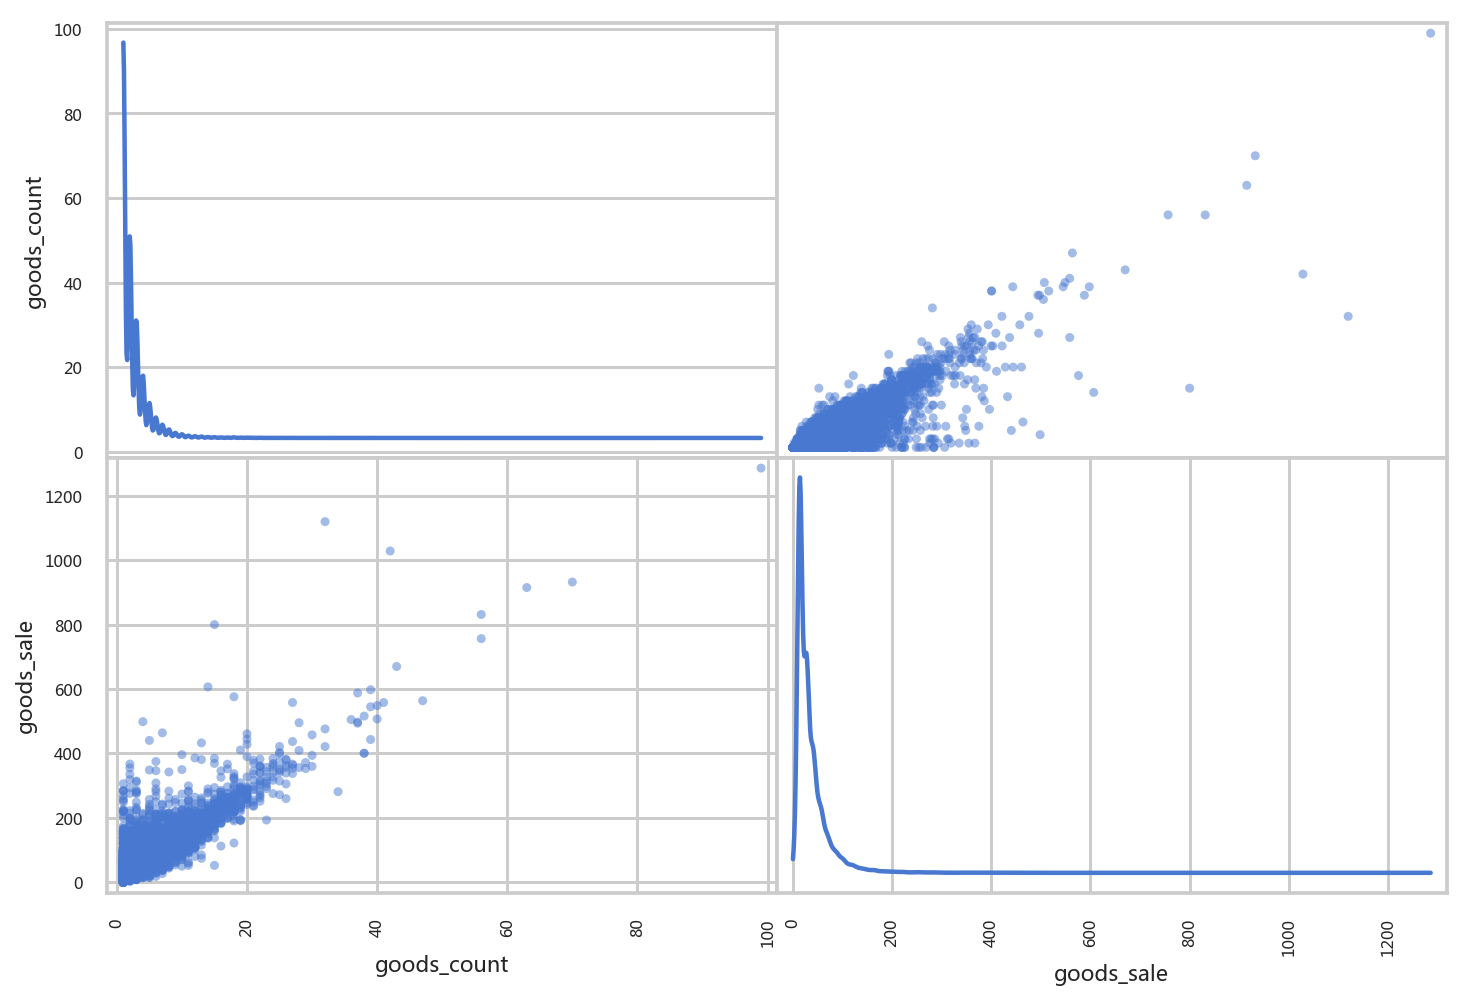

In [10]:
# 销售数量与销售金额 关系图
pd.plotting.scatter_matrix(df[['goods_count','goods_sale']], figsize=(12,8), diagonal='kde');

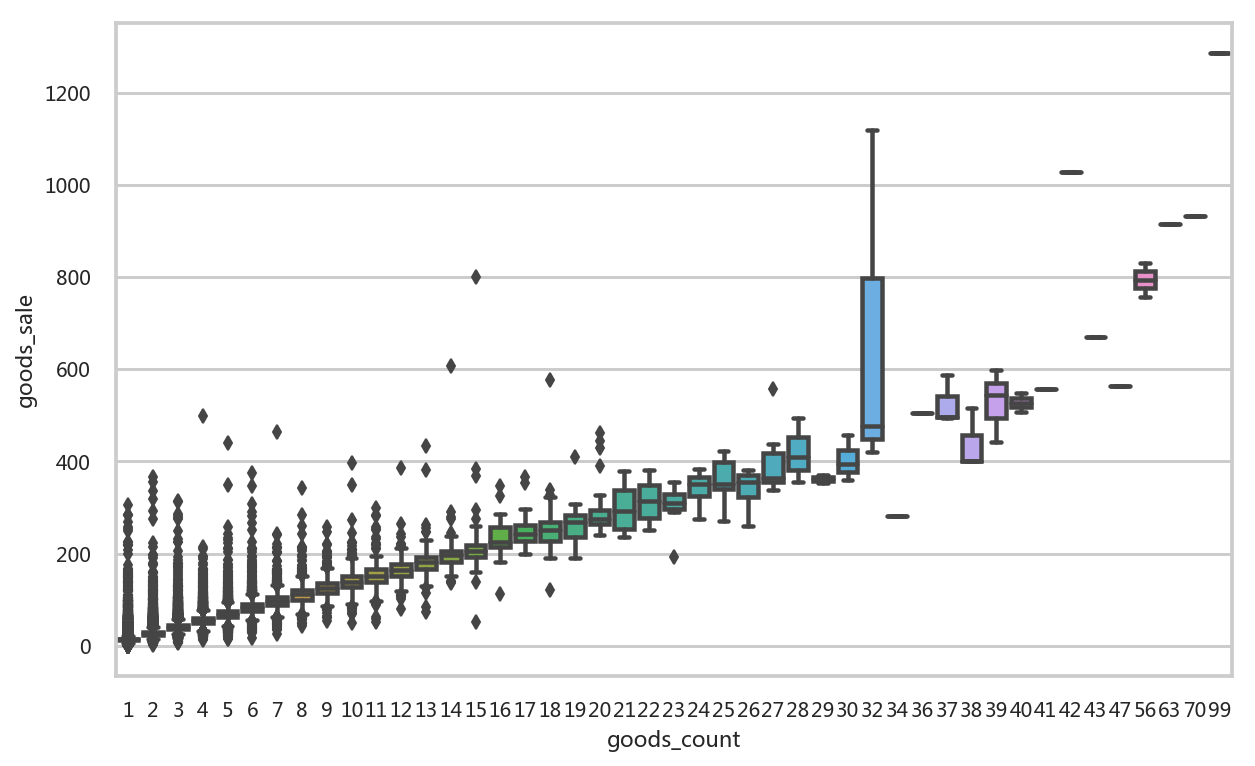

In [11]:
sns.boxplot(x='goods_count', y='goods_sale', data=df);

**结论3：新用户在199701-03三个月内大量产生，后期无新用户生成，整体来看，有近一半用户流失**
- 新用户只存在1997年的销售数据中，且只存在1997年前三个月的销售中
- 后期的用户均为前面新用户的转换

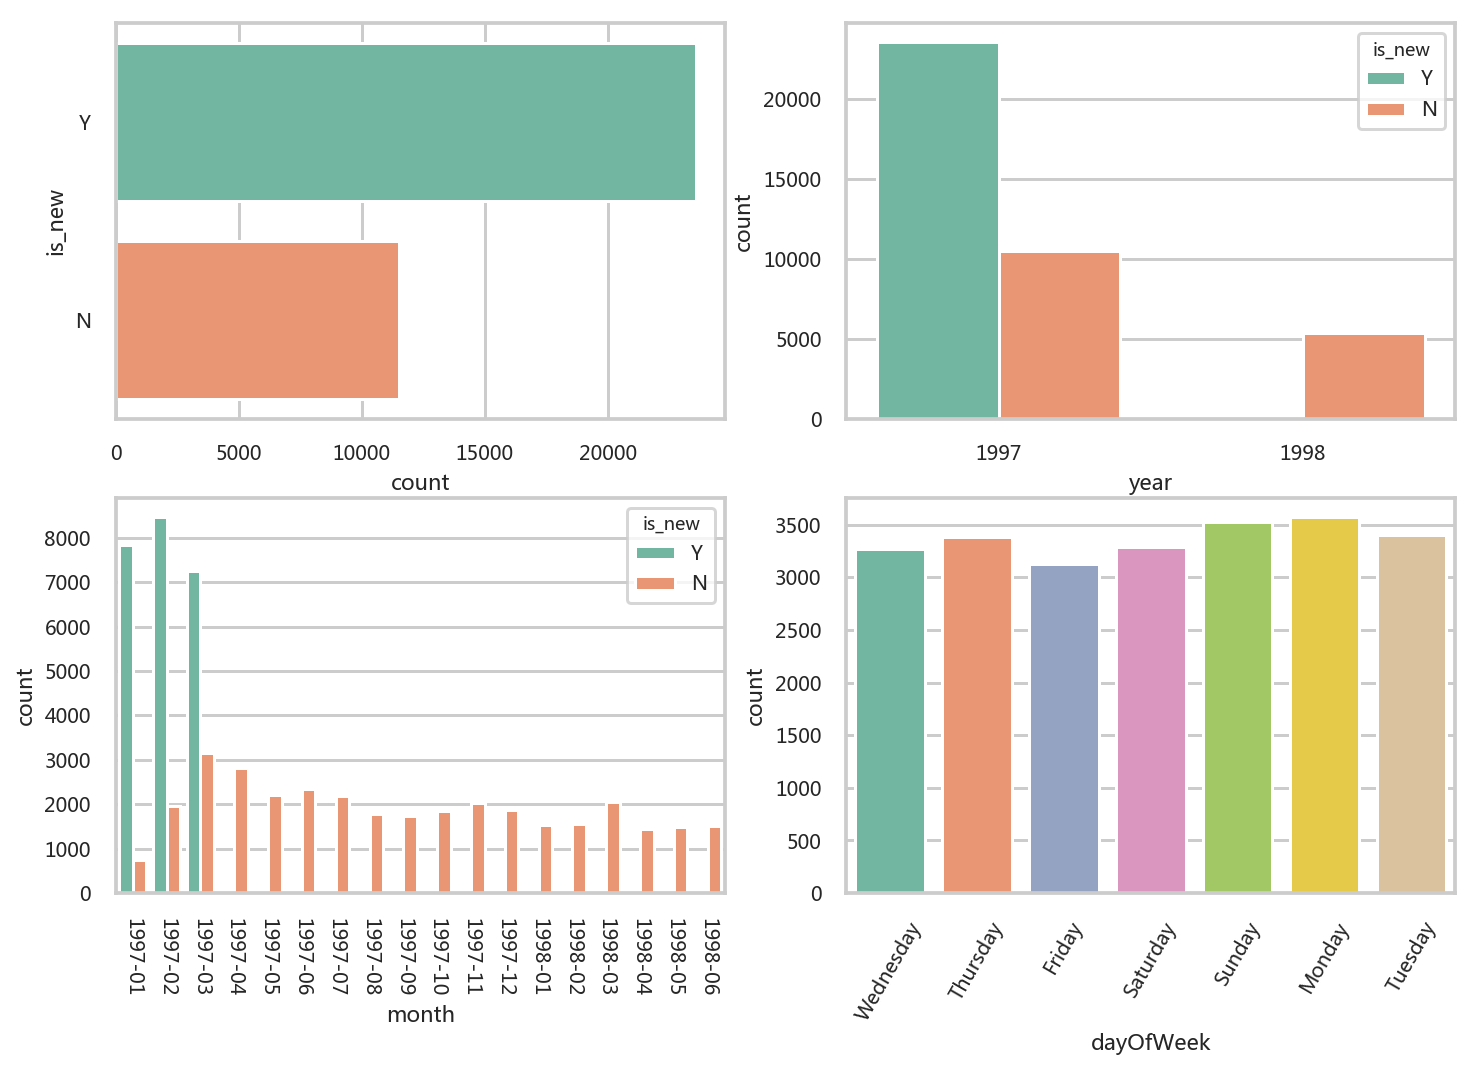

In [12]:
df1 = df[(df.year == '1997')&(df.is_new=='Y')][['member_id','dayOfWeek']].drop_duplicates() # 98年不含新用户
plt.rcParams['figure.figsize'] = (12, 8);
fig, axes = plt.subplots(2,2);
sns.countplot(y="is_new",data=df[['member_id','is_new']].drop_duplicates(), palette="Set2",ax=axes[0][0]);
sns.countplot(x="year", hue="is_new", data=df[['member_id','is_new','year']].drop_duplicates(), palette="Set2",ax=axes[0][1]);
sns.countplot(x="month", hue="is_new", data=df[['member_id','month','is_new']].drop_duplicates(), palette="Set2",ax=axes[1][0]);
axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(), rotation=-90);
sns.countplot(x="dayOfWeek",data=df1, palette="Set2",ax=axes[1][1]);
axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(), rotation=60);

**结论4：18年老用户的贡献远远不如17年新老用户**

In [13]:
# 因为会经常用到groupby方法，将此方法进行封装，尽可能的统计相关指标 然后结果在进行过滤

# 主要字段的统计方法
aggDict = {
        'member_id':pd.Series.nunique,
        'goods_count':np.sum,
        'goods_sale':np.sum,
    
        'user_all_sale':np.sum, # 这两个维度必须去重后才能统计
        'user_all_cnts':np.sum,
    }
#  统计后的字段重命名
colReDict = {
    'member_id':'all_users',
    'goods_count':'gcnt_by_one',                    
    'goods_sale':'gsale_by_one',
    
    'user_all_sale':'gcnt_by_all',# 这两个维度必须去重后才能统计
    'user_all_cnts':'gsale_by_all',   
    }

colSort=['users','orders','amount','costamt','saleamt','profit','all_serviceamt','vou_dis','points_dis','other_dis','all_dis']

# 基础指标统计,基础指标选择该函数即可
def getGroupRes(df, gpcol):
    res1 = df.groupby(gpcol,as_index=False).agg(aggDict).rename(columns=colReDict)
#     res1['one_avg_sale'] = res1.gsale_by_one/res1.gcnt_by_one
    return res1

# getGroupRes(df, ['year','is_new'])

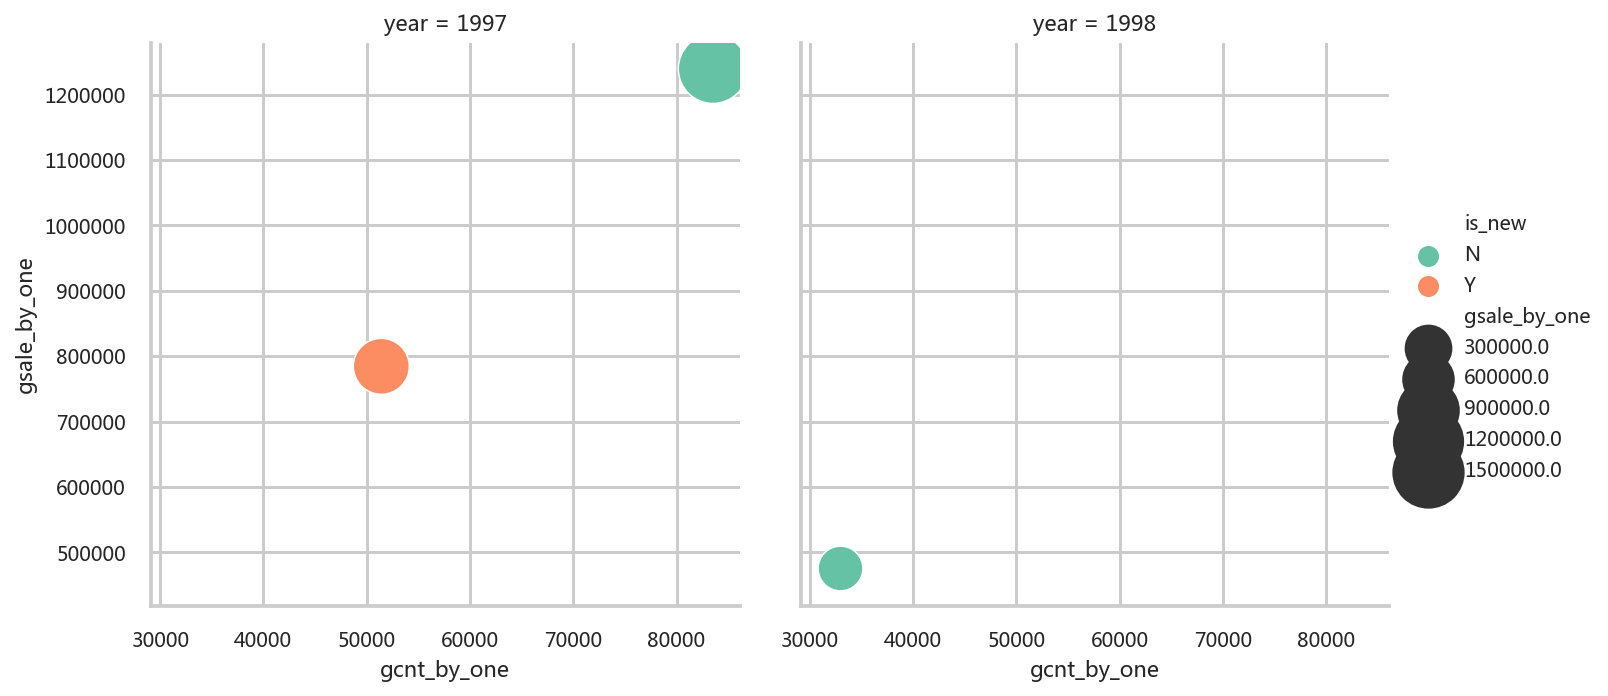

In [14]:
df1 = getGroupRes(df, ['year','is_new'])

g = sns.relplot(x="gcnt_by_one", y="gsale_by_one", hue="is_new", 
                size="gsale_by_one", # 指定目标维度显示点的大小
                palette="Set2",
                sizes=(500, 1200),col_wrap=2,
                col="year", data=df1);

### 基于时间轴进行统计
#### 月份维度主要指标统计
> 由于数据原因，该部分不涉及同比和环比，也不做主要指标的统计对比（放弃数据仪表盘展示）； 主要使用pyecharts进行

主要是在月份、周份等的主要指标展示；


In [15]:
df1 = getGroupRes(df, ['month'])[['month','all_users','gcnt_by_one','gsale_by_one']]
df1.head()

,month,all_users,gcnt_by_one,gsale_by_one
0,1997-01,7846,19416,299060.1700
1,1997-02,9633,24921,379590.0300
2,1997-03,9524,26159,393155.2700
3,1997-04,2822,9729,142824.4900
4,1997-05,2214,7275,107933.3000


In [16]:
bar = Bar(u'月份销售',width=950, height=400)
label_color = ['#CDCDB4','#FFAEB9'] + ['#8B1A1A','#7A378B']
bar.add('用户数', df1.month, df1.all_users, label_color=label_color,label_emphasis_textcolor='#000',
        mark_point=['min','max'])
bar.add('销售数量', df1.month, df1.gcnt_by_one, label_color=label_color,label_emphasis_textcolor='#000',
        mark_point=['min','max'])
line = Line()
line.add('销售额',df1.month, df1.gsale_by_one, yaxis_formatter='%',line_color = 'red',
         line_opacity=0.6,mark_point=['min'],line_width=2.5,label_emphasis_textcolor='#000')  
overlap = Overlap()
overlap.add(bar)
overlap.add(line, yaxis_index=1, is_add_yaxis=True)
overlap

In [19]:
### 今天有事 明天继续